![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark MIOST sea surface height maps (Geostrophic + Equatorial Wave + Barotrop modes)

<div style="text-align: right"><i> 2023-04-27 MIOST_SSH_GEOS_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of MIOST sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the MIOST system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
stat_output_filename = f'{output_dir}/stat_sla_miost_geos_eqwaves_barotrop.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_miost_geos_eqwaves_barotrop.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
list_of_file = sorted(glob('../data/independent_alongtrack/alg/2019/*.nc'))
ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
ds_alg

<xarray.Dataset>
Dimensions:         (time: 14437696)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-01T00:04:07.003014144 ... 2...
    longitude       (time) float64 dask.array<chunksize=(44621,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(44621,), meta=np.ndarray>
Data variables:
    cycle           (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    track           (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H11M29.716548S
    time_coverage_end:               2019-01-01T23:36:52Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2018-12-31T23:25:22Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## Sea Surface Height maps to evaluate

In [6]:
list_of_maps = sorted(glob('../data/maps/MIOST_geos_barotrop_eqwaves_global_allsat-alg/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1701, time: 365)
Coordinates:
  * longitude  (longitude) float64 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 -80.05 -79.95 -79.85 ... 89.75 89.85 89.95
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 1701, 3600), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [7]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

2024-09-11 20:19:51 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2024-09-11 20:20:05 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2024-09-11 20:20:17 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2024-09-11 20:20:31 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2024-09-11 20:20:43 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2024-09-11 20:20:58 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2024-09-11 20:21:10 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2024-09-11 20:21:23 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2024-09-11 20:21:35 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2024-09-11 20:21:47 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2024-09-11 20:21:59 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2024-09-11 20:22:10 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 14370249)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01T00:04:07.003014144 .....
Data variables: (12/13)
    cycle              (time) float32 126.0 126.0 126.0 ... 136.0 136.0 136.0
    track              (time) float32 9.0 9.0 9.0 9.0 ... 408.0 408.0 408.0
    sla_unfiltered     (time) float32 0.127 0.101 0.07 ... 0.007 0.056 0.01
    sla_filtered       (time) float32 0.117 0.128 0.142 ... 0.03 0.031 0.027
    dac                (time) float32 0.303 0.299 0.296 ... 0.172 0.171 0.172
    ocean_tide         (time) float32 -0.091 -0.096 -0.099 ... -0.304 -0.314
    ...                 ...
    lwe                (time) float32 -0.019 -0.019 -0.019 ... 0.014 0.014 0.016
    mdt                (time) float32 -0.104 -0.106 -0.108 ... -1.138 -1.154
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 64.42 64.33 64.25 ... 246.7 246.6 246.3
    latitude           (time) float64 69.9 69.95 70.01 ... -69.27 -69.32 -69.55
    msla_interpolated  (time) float64 0.1479 0.1481 0.1486 ... 0.02042 0.03124

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

In [8]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename)

2024-09-11 20:22:26 INFO     Compute mapping error all scales
2024-09-11 20:22:27 INFO     Compute mapping error for scales between 65.0 and 500.0 km


Total RMSE= 0.039903453727622815 m
Total RMSE score= 0.6924269948941044 m


2024-09-11 20:24:29 INFO     Compute binning statistics
2024-09-11 20:24:59 INFO     Compute statistics by oceanic regime
2024-09-11 20:25:47 INFO     Stat file saved as: ../results/stat_sla_miost_geos_eqwaves_barotrop.nc


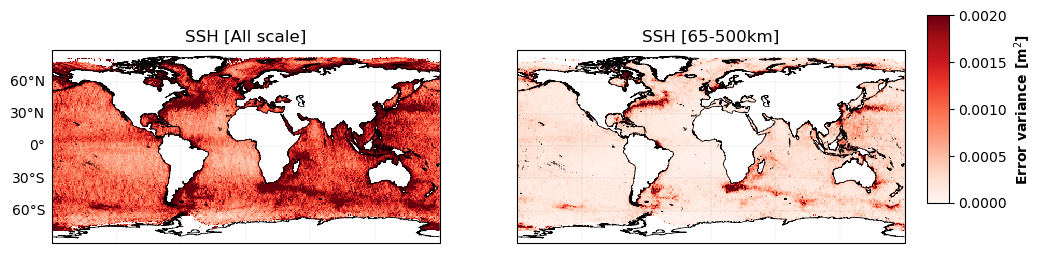

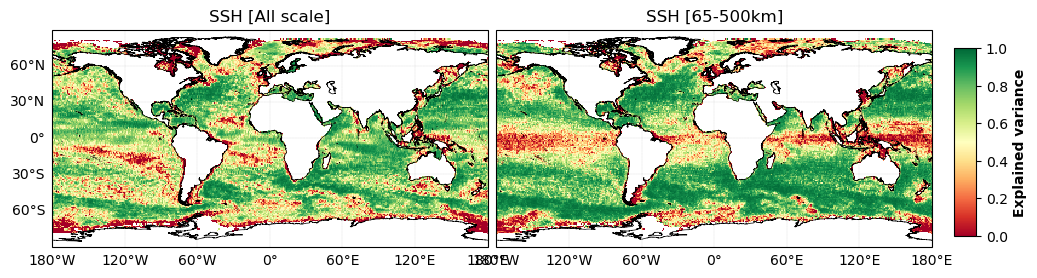

In [9]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [11]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [10]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.002546,0.008303,0.000548,0.001813,0.693327,0.697649
offshore_highvar,0.002893,0.053263,0.000958,0.021750,0.945677,0.955963
offshore_lowvar,0.001178,0.006299,0.000224,0.001775,0.812999,0.873896
equatorial_band,0.001399,0.005975,0.000307,0.000536,0.765894,0.426543
arctic,0.002417,0.007084,0.000407,0.001019,0.658796,0.600981
antarctic,0.003420,0.002344,0.000680,0.000753,-0.458979,0.096746


## 2.3 Compute Spectral scores

In [11]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght)

2024-09-11 20:26:00 INFO     Segment computation...
2024-09-11 20:26:12 INFO     Spectral analysis...
2024-09-11 20:41:23 INFO     Saving ouput...
2024-09-11 20:41:32 INFO     PSD file saved as: ../results/psd_sla_miost_geos_eqwaves_barotrop.nc


Averaged effective resolution: 213.3587748015752 km


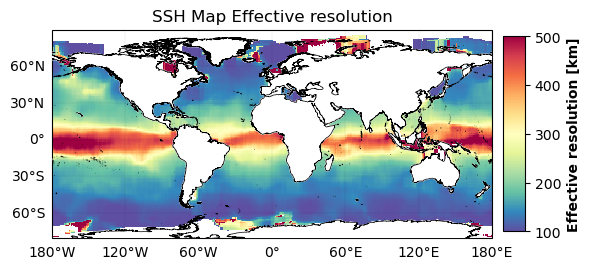

In [12]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename)

In [14]:
plot_psd_scores(psd_output_filename)

:Layout
   .DynamicMap.I   :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_alongtrack   :Curve   [wavelenght]   (psd_ref)
         .Curve.NOISE_alongtrack :Curve   [wavelenght]   (noise)
         .Curve.PSD_map          :Curve   [wavelenght]   (psd_study)
         .Curve.PSD_err          :Curve   [wavelenght]   (psd_diff)
   .DynamicMap.II  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_map_over_PSD_ref :Curve   [wavelenght]   (psd_ratio)
         .Curve.I                    :Curve   [wavelenght]   (coherence)
   .DynamicMap.III :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (psd_score)
         .Curve.II :Curve   [wavelenght]   (coherence)
   .DynamicMap.IV  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (coherence)
         .Curve.II :Curve   [wavelenght]   (coherence)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box